### Importing Libraries

In [1]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy
import string
import random
import string
from sklearn import linear_model
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc

In [2]:
import pandas as pd

In [3]:
df=pd.read_csv('ratebeer_subset.csv')

/var/folders/3p/kspp193j03jcwfvhclp18x580000gn/T/ipykernel_67365/2484777156.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('ratebeer_subset.csv')


In [4]:
allRatings = []
for index, row in df.iterrows():
    user = row['review/profileName']
    item = row['beer/name']
    rating = row['review/overall']
    allRatings.append((user, item, rating))

In [5]:
ratingsTrain = allRatings[:450000]
ratingsValid = allRatings[450000:]
ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)
for u,i,r in ratingsTrain:
    ratingsPerUser[u].append((i,r))
    ratingsPerItem[i].append((u,r))

### Creating Negative Samples

In [6]:
userSet = set()
beerSet = set()
boughtSet = set()
for u,i,r in allRatings:
    userSet.add(u)
    beerSet.add(i)
    boughtSet.add((u,i))
lUserSet = list(userSet)
lbeerSet = list(beerSet)
notbought = set()
for u,i,r in ratingsValid:
    i = random.choice(lbeerSet)
    while ((u,i) in boughtSet or (u,i) in notbought):
        i = random.choice(lbeerSet)
    notbought.add((u,i))
boughtValid = set()
for u,i,r in ratingsValid:
    boughtValid.add((u,i))

In [7]:
len(notbought)

50000

### Creating Features

In [8]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom > 0:
        return numer/denom
    return 0

In [9]:
def CosineSet(s1, s2):
    numer = len(s1.intersection(s2))
    denom = math.sqrt(len(s1)) * math.sqrt(len(s2))
    if denom == 0:
        return 0
    return numer / denom

In [10]:
def extract_features(user, beer, ratingsPerUser, ratingsPerItem):
    features = []
    max_jaccard = 0
    users_b = set(ratingsPerItem[beer])
    for read_beer, _ in ratingsPerUser[user]:
        users_b_prime = set(ratingsPerItem[read_beer])
        max_jaccard = max(max_jaccard, Jaccard(users_b, users_b_prime))
    features.append(max_jaccard)
    max_cosine = 0
    for read_beer, _ in ratingsPerUser[user]:
        users_b_prime = set(ratingsPerItem[read_beer])
        max_cosine = max(max_cosine, CosineSet(users_b, users_b_prime))
    features.append(max_cosine)
    user_similarity = 0
    user_beers = ratingsPerUser.get(user, [])
    if len(user_beers) > 0:
        for other_user in users_b:
            if other_user != user:
                common_beers = set(user_beers) & set(ratingsPerUser.get(other_user, []))
                user_similarity += len(common_beers) / len(user_beers)
    features.append(user_similarity)
    features.append(len(ratingsPerUser[user]))
    features.append(len(set(ratingsPerUser[user])))
    features.append(len(ratingsPerItem[beer]))
    features.append(1 / (1 + len(ratingsPerItem[beer])))
    return features

In [11]:
def prepare_dataset(beerValid, notBeer, ratingsPerUser, ratingsPerItem):
    data = []
    labels = []
    for label, sample in [(1, beerValid), (0, notBeer)]:
        for u, b in sample:
            features = extract_features(u, b, ratingsPerUser, ratingsPerItem)
            data.append(features)
            labels.append(label)
    return pd.DataFrame(data), np.array(labels)

### Training Models

In [12]:
X_scaled,y = prepare_dataset(boughtValid, notbought, ratingsPerUser, ratingsPerItem)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.20, random_state=42)
rf_model = RandomForestClassifier(max_depth=10, max_features='log2',min_samples_leaf=4,min_samples_split=10,n_estimators=200)
rf_model.fit(X_train, y_train)
lr_model = LogisticRegression(C=10, penalty='l1',solver='liblinear')
lr_model.fit(X_train, y_train)
xgb_model = XGBClassifier(n_estimators=300, max_depth=10, learning_rate=0.05, subsample=0.8)
xgb_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_val)
lr_predictions = lr_model.predict(X_val)
y_pred = xgb_model.predict(X_val)
print("XGBoost Accuracy:", accuracy_score(y_val, y_pred))
print(f"Random Forest Accuracy: {accuracy_score(y_val, rf_predictions):.4f}")
print(f"Logistic Regression Accuracy: {accuracy_score(y_val, lr_predictions):.4f}")

/Users/asherjacob/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


XGBoost Accuracy: 0.7941382414724417
Random Forest Accuracy: 0.8002
Logistic Regression Accuracy: 0.7604


### Evaluation

In [13]:
auc_score_xg = roc_auc_score(y_val, y_pred)
print(f"AUC-ROC: {auc_score_xg:.4f}")

AUC-ROC: 0.7943


In [14]:
auc_score_rf = roc_auc_score(y_val, rf_predictions)
print(f"AUC-ROC: {auc_score_rf:.4f}")

AUC-ROC: 0.8004


In [15]:
auc_score_lr = roc_auc_score(y_val, lr_predictions)
print(f"AUC-ROC: {auc_score_lr:.4f}")

AUC-ROC: 0.7608


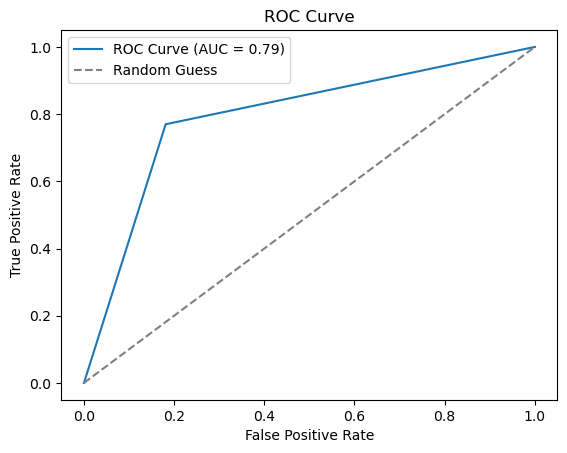

In [16]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score_xg:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

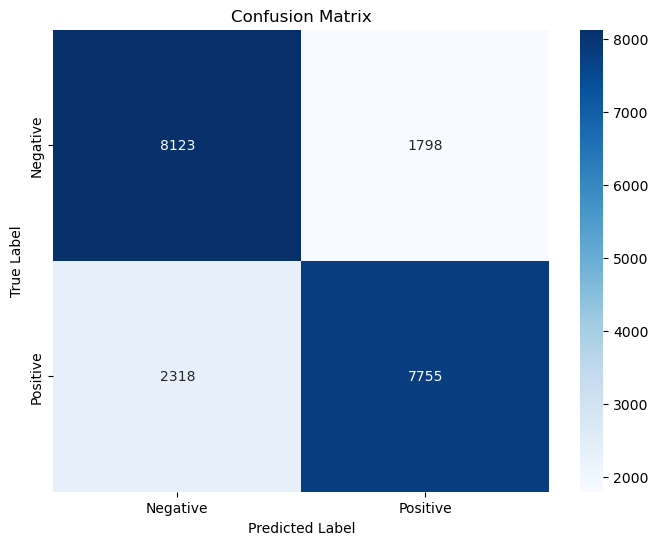

In [17]:
cf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Positive"], 
    yticklabels=["Negative", "Positive"]
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


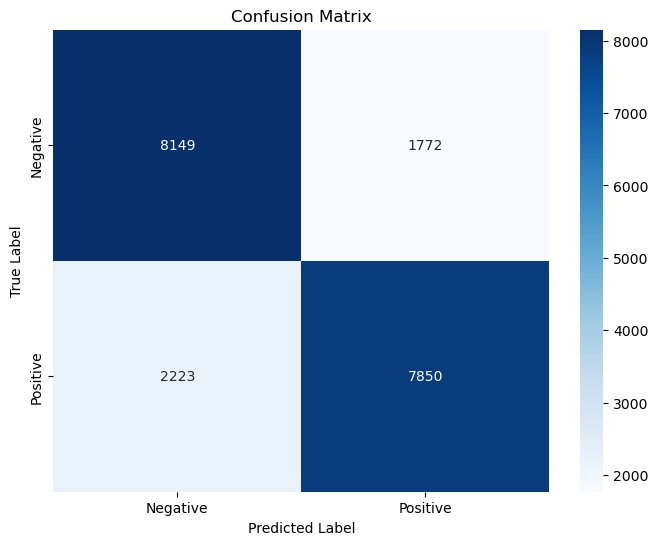

In [18]:
cf_matrix = confusion_matrix(y_val, rf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Positive"],  
    yticklabels=["Negative", "Positive"]
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


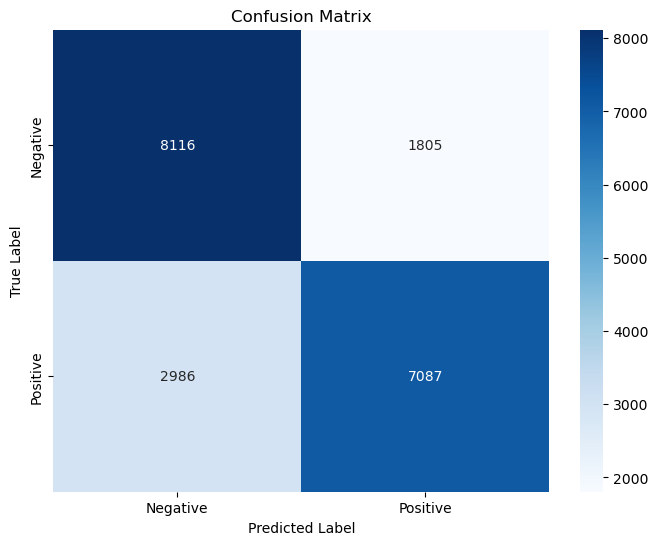

In [19]:
cf_matrix = confusion_matrix(y_val, lr_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Positive"], 
    yticklabels=["Negative", "Positive"]
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


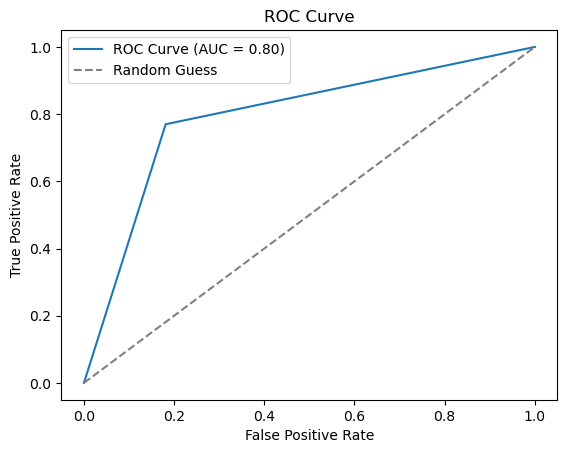

In [20]:
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score_rf:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

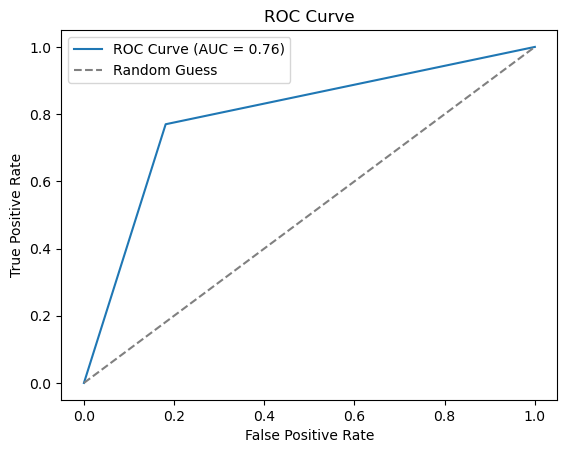

In [21]:
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score_lr:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [22]:
itemsPerUser = defaultdict(list)
usersPerItem = defaultdict(list)
for u,i,r in ratingsTrain:
    itemsPerUser[u].append(i)
    usersPerItem[i].append(u)

### Baseline 

In [23]:
def compute_random_baseline_accuracy(boughtValid, notbought):
    correct = 0
    total = 0
    for user, beer in boughtValid:
        total += 1
        if random.choice([True, False]):
            correct += 1
    for user, beer in notbought:
        total += 1
        if not random.choice([True, False]):
            correct += 1

    accuracy = correct / total if total > 0 else 0
    return accuracy

accuracy_random = compute_random_baseline_accuracy(boughtValid, notbought)
print(f"Random baseline accuracy: {accuracy_random:.4f}")

Random baseline accuracy: 0.5001


In [24]:
def random_baseline_accuracy(boughtValid, notbought, prob_buy):
    correct = 0
    total = 0
    for user, beer in boughtValid:
        total += 1
        if random.random() < prob_buy:
            correct += 1
    for user, beer in notbought:
        total += 1
        if random.random() >= prob_buy:
            correct += 1

    accuracy = correct / total if total > 0 else 0
    return accuracy
prob_buy = len(boughtValid) / (len(boughtValid) + len(notbought))
accuracy = random_baseline_accuracy(boughtValid, notbought, prob_buy)
print(f"Random baseline accuracy: {accuracy:.4f}")

Random baseline accuracy: 0.5009


In [25]:
def user_popularity_baseline_accuracy(boughtValid, notbought, ratingsPerUser):
    correct = 0
    total = 0
    user_purchase_counts = {user: len(ratingsPerUser[user]) for user in ratingsPerUser}

    for user, beer in boughtValid:
        total += 1
        if user_purchase_counts.get(user, 0) > 10:  # Example threshold
            correct += 1
    for user, beer in notbought:
        total += 1
        if user_purchase_counts.get(user, 0) <= 10:
            correct += 1

    accuracy = correct / total if total > 0 else 0
    return accuracy

accuracy = user_popularity_baseline_accuracy(boughtValid, notbought, ratingsPerUser)
print(f"User popularity baseline accuracy: {accuracy:.4f}")

User popularity baseline accuracy: 0.4999


In [26]:
def active_user_baseline_accuracy(boughtValid, notbought, ratingsPerUser):
    correct = 0
    total = 0
    for user, beer in boughtValid:
        total += 1
        if len(ratingsPerUser.get(user, [])) > 100:  # Threshold for active users
            correct += 1
    for user, beer in notbought:
        total += 1
        if len(ratingsPerUser.get(user, [])) <= 100:
            correct += 1

    accuracy = correct / total if total > 0 else 0
    return accuracy
accuracy = active_user_baseline_accuracy(boughtValid, notbought, ratingsPerUser)
print(f"Active user baseline accuracy: {accuracy:.4f}")


Active user baseline accuracy: 0.5001


### BPR

In [27]:
userIDs = {user for user, _, _ in allRatings}
itemIDs = {item for _ , item, _ in allRatings}
userIDs = {user: idx for idx, user in enumerate(userIDs)}  
itemIDs = {item: idx for idx, item in enumerate(itemIDs)} 

In [28]:
items = list(itemIDs)

In [29]:
optimizer = tf.keras.optimizers.legacy.Adam(0.1)

In [30]:
class BPRbatch(tf.keras.Model):
    def __init__(self, K, lamb):
        super(BPRbatch, self).__init__()
        self.betaI = tf.Variable(tf.random.normal([len(itemIDs)],stddev=0.001))
        self.gammaU = tf.Variable(tf.random.normal([len(userIDs),K],stddev=0.001))
        self.gammaI = tf.Variable(tf.random.normal([len(itemIDs),K],stddev=0.001))
        self.lamb = lamb
    def predict(self, u, i):
        p = self.betaI[i] + tf.tensordot(self.gammaU[u], self.gammaI[i], 1)
        return p
    def reg(self):
        return self.lamb * (tf.nn.l2_loss(self.betaI) +\
                            tf.nn.l2_loss(self.gammaU) +\
                            tf.nn.l2_loss(self.gammaI))
    def score(self, sampleU, sampleI):
        u = tf.convert_to_tensor(sampleU, dtype=tf.int32)
        i = tf.convert_to_tensor(sampleI, dtype=tf.int32)
        beta_i = tf.nn.embedding_lookup(self.betaI, i)
        gamma_u = tf.nn.embedding_lookup(self.gammaU, u)
        gamma_i = tf.nn.embedding_lookup(self.gammaI, i)
        x_ui = beta_i + tf.reduce_sum(tf.multiply(gamma_u, gamma_i), 1)
        return x_ui
    def call(self, sampleU, sampleI, sampleJ):
        x_ui = self.score(sampleU, sampleI)
        x_uj = self.score(sampleU, sampleJ)
        return -tf.reduce_mean(tf.math.log(tf.math.sigmoid(x_ui - x_uj)))

In [31]:
def trainingStepBPR(model, interactions):
    Nsamples = 50000
    with tf.GradientTape() as tape:
        sampleU, sampleI, sampleJ = [], [], []
        for _ in range(Nsamples):
            u,i,_ = random.choice(interactions) 
            j = random.choice(items) 
            while j in itemsPerUser[u]:
                j = random.choice(items)
            sampleU.append(userIDs[u])
            sampleI.append(itemIDs[i])
            sampleJ.append(itemIDs[j])
        loss = model(sampleU,sampleI,sampleJ)
        loss += model.reg()
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients((grad, var) for
                              (grad, var) in zip(gradients, model.trainable_variables)
                              if grad is not None)
    return loss.numpy()

In [32]:
modelBPR = BPRbatch(5, 0.00001)

In [33]:
for i in range(100):
    obj = trainingStepBPR(modelBPR, ratingsTrain)
    if (i % 10 == 9): print("iteration " + str(i+1) + ", objective = " + str(obj))

iteration 10, objective = 0.6147077
iteration 20, objective = 0.57066345
iteration 30, objective = 0.55193394
iteration 40, objective = 0.56185526
iteration 50, objective = 0.56630117
iteration 60, objective = 0.56513107
iteration 70, objective = 0.5557223
iteration 80, objective = 0.54647946
iteration 90, objective = 0.5440279
iteration 100, objective = 0.5441367


In [34]:
def get_bpr_scores(model, user_item_pairs):
    scores = {}
    for u, i in user_item_pairs:
        u_id = userIDs[u]
        i_id = itemIDs[i]
        score = model.predict(u_id, i_id)  
        scores[(u, i)] = score
    return scores

In [35]:
prediction_pairs = list(boughtValid) + list(notbought)
bpr_scores = get_bpr_scores(modelBPR, prediction_pairs)

### Using BPR Score as a feature

In [36]:
def prepare_dataset(beerValid, notBeer, ratingsPerUser, ratingsPerItem):
    data = []
    labels = []
    for label, sample in [(1, beerValid), (0, notBeer)]:
        for u, b in sample:
            features = extract_features(u, b, ratingsPerUser, ratingsPerItem)
            bpr_score = bpr_scores.get((u, b), 0)  
            features.append(bpr_score) 
            data.append(features)
            labels.append(label)
    return pd.DataFrame(data), np.array(labels)

In [37]:
X_scaled, y = prepare_dataset(boughtValid, notbought, ratingsPerUser, ratingsPerItem)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.20, random_state=42)

In [38]:
X_train.head()

,0,1,2,3,4,5,6,7
46867,0.250000,0.408248,0.0,3218,3210,4,0.200000,"tf.Tensor(0.8663559, shape=(), dtype=float32)"
12604,0.071429,0.133631,0.0,18,18,7,0.125000,"tf.Tensor(0.1678444, shape=(), dtype=float32)"
70299,0.000000,0.000000,0.0,153,152,9,0.100000,"tf.Tensor(0.40959707, shape=(), dtype=float32)"
99176,0.090909,0.166667,0.0,1932,1927,6,0.142857,"tf.Tensor(-0.4791549, shape=(), dtype=float32)"
48021,0.000000,0.000000,0.0,15,15,18,0.052632,"tf.Tensor(0.58381367, shape=(), dtype=float32)"


In [39]:
df = X_train.copy()  
for col in df.columns:
    if isinstance(df[col].iloc[0], tf.Tensor):
        df[col] = df[col].apply(lambda x: x.numpy().item())
print(df.head())
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_features, columns=df.columns)

              0         1    2     3     4   5         6         7
46867  0.250000  0.408248  0.0  3218  3210   4  0.200000  0.866356
12604  0.071429  0.133631  0.0    18    18   7  0.125000  0.167844
70299  0.000000  0.000000  0.0   153   152   9  0.100000  0.409597
99176  0.090909  0.166667  0.0  1932  1927   6  0.142857 -0.479155
48021  0.000000  0.000000  0.0    15    15  18  0.052632  0.583814


In [40]:
import tensorflow as tf
import pandas as pd
df_val = X_val.copy()  
for col in df_val.columns:
    if isinstance(df_val[col].iloc[0], tf.Tensor):
        df_val[col] = df_val[col].apply(lambda x: x.numpy().item())
print(df_val.head())
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_val)
scaled_df_val = pd.DataFrame(scaled_features, columns=df_val.columns)

              0         1    2     3     4    5         6         7
95423  0.000000  0.000000  0.0    14    14    1  0.500000 -0.187493
49916  0.002915  0.005942  0.0    17    17  273  0.003650  2.780714
74449  0.000000  0.000000  0.0  1932  1927    0  1.000000 -1.356607
36998  0.166667  0.316228  0.0   537   536    2  0.333333  0.018611
35054  0.333333  0.500000  0.0  1659  1656    2  0.333333  1.323537


### Training Models

In [41]:
rf_model = RandomForestClassifier(max_depth=10, max_features='log2',min_samples_leaf=4,min_samples_split=10,n_estimators=200)
rf_model.fit(df, y_train)
lr_model = LogisticRegression(C=10, penalty='l1',solver='liblinear')
lr_model.fit(df, y_train)
xgb_model = XGBClassifier(n_estimators=300, max_depth=10, learning_rate=0.05, subsample=0.8)
xgb_model.fit(df, y_train)
rf_predictions = rf_model.predict(df_val)
lr_predictions = lr_model.predict(df_val)
y_pred = xgb_model.predict(df_val)
print("XGBoost Accuracy:", accuracy_score(y_val, y_pred))
print(f"Random Forest Accuracy: {accuracy_score(y_val, rf_predictions):.4f}")
print(f"Logistic Regression Accuracy: {accuracy_score(y_val, lr_predictions):.4f}")

/Users/asherjacob/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


XGBoost Accuracy: 0.8112433730119035
Random Forest Accuracy: 0.8139
Logistic Regression Accuracy: 0.7782


In [42]:
def compute_accuracy(modelBPR, boughtValid, notbought, threshold, userIDs, itemIDs):
    bought_scores = get_bpr_scores(modelBPR, boughtValid)
    notbought_scores = get_bpr_scores(modelBPR, notbought)
    true_positive = sum(1 for (u, i), score in bought_scores.items() if score > threshold)
    false_negative = sum(1 for (u, i), score in bought_scores.items() if score <= threshold)
    true_negative = sum(1 for (u, i), score in notbought_scores.items() if score <= threshold)
    false_positive = sum(1 for (u, i), score in notbought_scores.items() if score > threshold)
    total = true_positive + false_negative + true_negative + false_positive
    accuracy = (true_positive + true_negative) / total if total > 0 else 0
    return accuracy
threshold = 0.3  
accuracy = compute_accuracy(modelBPR, boughtValid, notbought, threshold,userIDs,itemIDs)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.76


### Creating negative samples using threshold

In [43]:
def get_most_popular_beers(boughtValid):
    beerCount = defaultdict(int)
    totalRead = 0
    for user, beer in boughtValid:
        beerCount[beer] += 1
        totalRead += 1
    mostPopular = [(beerCount[x], x) for x in beerCount]
    mostPopular.sort(reverse=True)  
    return1 = set()
    count = 0
    for ic, beer in mostPopular:
        count += ic
        return1.add(beer)
        if count > totalRead / 2:
            break

    return return1

def compute_baseline_accuracy(return1, boughtValid, notbought):
    correct = 0
    total = 0
    for user, beer in boughtValid:
        total += 1
        if beer in return1:
            correct += 1
    for user, beer in notbought:
        total += 1
        if beer not in return1:
            correct += 1

    accuracy = correct / total if total > 0 else 0
    return accuracy
return1 = get_most_popular_beers(boughtValid)
accuracy = compute_baseline_accuracy(return1, boughtValid, notbought)
print(f"Baseline accuracy: {accuracy:.4f}")

Baseline accuracy: 0.7115


In [44]:
userSet = set()
beerSet = set()
boughtSet = set()

for u, i, r in allRatings:
    userSet.add(u)
    beerSet.add(i)
    boughtSet.add((u, i))

lUserSet = list(userSet)
lbeerSet = list(beerSet)

positiveSamples = set()
negativeSamples = set()

for u, i, r in ratingsValid:
    if r >= 13:  
        positiveSamples.add((u, i))
    else:        
        negativeSamples.add((u, i))
print("Number of positive samples:", len(positiveSamples))
print("Number of negative samples:", len(negativeSamples))


Number of positive samples: 30756
Number of negative samples: 19211


In [45]:
df.head()

,0,1,2,3,4,5,6,7
46867,0.250000,0.408248,0.0,3218,3210,4,0.200000,0.866356
12604,0.071429,0.133631,0.0,18,18,7,0.125000,0.167844
70299,0.000000,0.000000,0.0,153,152,9,0.100000,0.409597
99176,0.090909,0.166667,0.0,1932,1927,6,0.142857,-0.479155
48021,0.000000,0.000000,0.0,15,15,18,0.052632,0.583814


In [46]:
def prepare_dataset(beerValid, notBeer, ratingsPerUser, ratingsPerItem):
    data = []
    labels = []
    for label, sample in [(1, beerValid), (0, notBeer)]:
        for u, b in sample:
            features = extract_features(u, b, ratingsPerUser, ratingsPerItem)
            data.append(features)
            labels.append(label)
    return pd.DataFrame(data), np.array(labels)

### Training Models 

In [47]:
X_scaled,y = prepare_dataset(positiveSamples, negativeSamples, ratingsPerUser, ratingsPerItem)
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.20, random_state=42)
rf_model = RandomForestClassifier(max_depth=10, max_features='log2',min_samples_leaf=4,min_samples_split=10,n_estimators=200)
rf_model.fit(X_train, y_train)
lr_model = LogisticRegression(C=10, penalty='l1',solver='liblinear')
lr_model.fit(X_train, y_train)
xgb_model = XGBClassifier(n_estimators=300, max_depth=10, learning_rate=0.05, subsample=0.8)
xgb_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_val)
lr_predictions = lr_model.predict(X_val)
y_pred = xgb_model.predict(X_val)
print("XGBoost Accuracy:", accuracy_score(y_val, y_pred))
print(f"Random Forest Accuracy: {accuracy_score(y_val, rf_predictions):.4f}")
print(f"Logistic Regression Accuracy: {accuracy_score(y_val, lr_predictions):.4f}")

/Users/asherjacob/Library/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


XGBoost Accuracy: 0.63027816690014
Random Forest Accuracy: 0.6384
Logistic Regression Accuracy: 0.6175
